## BBC News Classification

_Completed as part of CU Boulder's **Unsupervised Algorithms in Machine Learning** course._

This project uses both an unsupervised and a supervised model to predict the categories of a BBC news article dataset.

The BBC news article dataset was provided on Kaggle here:
https://www.kaggle.com/c/learn-ai-bbc/overview

_Citation:_

BBC. (2019, December). BBC News Classification, v1. Retrieved August 14, 2022 from https://www.kaggle.com/competitions/learn-ai-bbc/data.


In [79]:
# First we will import all needed dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import re
import spacy
import itertools
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Vectorization libraries and configuration
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec

In [88]:
# Data import
train = pd.read_csv("data/BBC News Train.csv")
# There is an unlabelled test set available for the Kaggle competition
# test = pd.read_csv("data/BBC News Test.csv")

### Exploratory Data Analysis (EDA)

First we will begin by looking the size of our data, features, and data types.

In [89]:

print(train.head(5))
print("\nTrain:")
print(train.info())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


The BBC news article train dataset is relatively small, with 1,490 articles for which there is only one feature, "Text", and our label is "Category".

It looks like the article text has already been processed a bit, lowercasing content and removing some punctuation. We should also verify we don't have null values, and look at what content is contained in "Text".

In [53]:
# Check for any null/null-like values
null_like = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.', '', ' ', '   ']

for c in train.columns:
    string_null = np.array([x in null_like for x in train[c]])
    print(c, train[c].isnull().sum(), string_null.sum())

ArticleId 0 0
Text 0 0
Category 0 0
ArticleId 0 0
Text 0 0


In [94]:
# Identify frequent work tokens to see what can be cleaned out
word_freq_preview = defaultdict(int)

for idx, article in train.iterrows():
    text = article['Text']
    for i in sent_tokenize(text):
        temp = []
        # tokenize the sentence into words
        for j in word_tokenize(i):
            temp.append(j)
            word_freq_preview[j] += 1
print(len(word_freq_preview))
word_freq_preview_sorted = sorted(word_freq_preview, key=word_freq_preview.get, reverse=True)
print("Uncleaned, top 20 most frequent:\n", word_freq_preview_sorted[:20])

28178
Uncleaned, top 20 most frequent:
 ['the', '.', 'to', 'of', 'and', 'a', 'in', 's', 'for', 'is', 'that', 'it', 'on', 'said', 'was', 'he', 'be', 'with', 'has', 'as']


In [95]:
# Top 20 most frequent words:
# ['the', '.', 'to', 'of', 'and', 'a', 'in', 's', 'for', 'is', 'that', 'it', 'on', 'said', 'was', 'he', 'be', 'with', 'has', 'as']
# Lots of stop words, so we need to do some cleaning!

# Using helpers from: https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Removes stopwords and lemmatizes
    txt = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(txt)
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in train['Text'])

train['Clean Text'] = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

The now clean text data needs to be prepared for interpretation. Simply passing arbitrary strings (each of which are unique) will not produce any results with matrix factorization methods - or most any machine learning methods without _some_ preprocessing.

Now to prepare the data for training by tokenizing the text content, then it will be ready for using Word2Vec to produce vectors from word embeddings.

In [55]:

# for installing missing corpora if needed
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [56]:
# Collect tokens for each article, and check frequent words 
# for verification of earlier cleaning
tokens_by_idx = []
word_freq = defaultdict(int)

for idx, article in train.iterrows():
    text = article['Clean Text']
    for i in sent_tokenize(text):
        temp = []
        for j in word_tokenize(i):
            temp.append(j.lower())
            word_freq[j.lower()] += 1
        tokens_by_idx.append(temp)

# With stop words, unique word count was 28,178
print(len(word_freq))
print(tokens_by_idx[0],tokens_by_idx[20])

18437
['worldcom', 'ex', 'boss', 'launch', 'defence', 'lawyer', 'defend', 'worldcom', 'chief', 'bernie', 'ebber', 'battery', 'fraud', 'charge', 'call', 'company', 'whistleblow', 'witness', 'cynthia', 'cooper', 'worldcom', 's', 'ex', 'head', 'internal', 'accounting', 'alert', 'director', 'irregular', 'accounting', 'practice', 'telecom', 'giant', 'warning', 'lead', 'collapse', 'firm', 'follow', 'discovery', 'bn', 'bn', 'accounting', 'fraud', 'mr', 'ebber', 'plead', 'guilty', 'charge', 'fraud', 'conspiracy', 'prosecution', 'lawyer', 'argue', 'mr', 'ebber', 'orchestrate', 'series', 'accounting', 'trick', 'worldcom', 'order', 'employee', 'hide', 'expense', 'inflate', 'revenue', 'meet', 'wall', 'street', 'earning', 'estimate', 'ms', 'cooper', 'run', 'consulting', 'business', 'tell', 'jury', 'new', 'york', 'wednesday', 'external', 'auditor', 'arthur', 'andersen', 'approve', 'worldcom', 's', 'accounting', 'early', 'say', 'andersen', 'give', 'green', 'light', 'procedure', 'practice', 'worldcom'

In [57]:
word_freq_sorted = sorted(word_freq, key=word_freq.get, reverse=True)
print("Top 20 most frequent:\n", word_freq_sorted[:20])

Top 20 most frequent:
 ['s', 'say', 'year', 'mr', 'new', 'people', 'm', 'good', 'win', 'time', 'game', 'film', 'world', 't', 'uk', 'come', 'government', 'play', 'go', 'work']


In [58]:
# Train Word2Vec model to build word embedding space
bag_of_words_model = gensim.models.Word2Vec(tokens_by_idx, min_count=5, vector_size=100, window=3, epochs=50)

# Print example similarity scores using embeddings
print("Score 'lawyer' <-> 'defence': ", bag_of_words_model.wv.similarity('lawyer', 'defence'))
print("Score 'lawyer' <-> 'economy':", bag_of_words_model.wv.similarity('lawyer', 'economy'))

Score 'lawyer' <-> 'defence':  0.26813266
Score 'lawyer' <-> 'economy': -0.097674064


In [59]:
# Further exploration of how well our bag of words model is associating words
bag_of_words_model.wv.most_similar(positive=["economy"])

[('economic', 0.5649333000183105),
 ('gdp', 0.5107204914093018),
 ('export', 0.507564127445221),
 ('manufacturing', 0.49129581451416016),
 ('inflation', 0.47642725706100464),
 ('growth', 0.4555329978466034),
 ('deficit', 0.4527810513973236),
 ('spending', 0.45186713337898254),
 ('recovery', 0.44436660408973694),
 ('lending', 0.44104188680648804)]

#### EDA: Word token distribution

In [60]:
sorted_counts = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

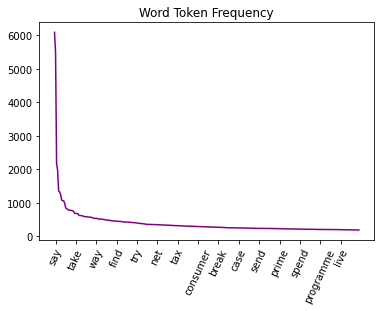

In [61]:

x, y = zip(*sorted_counts[:300]) # unpack a list of pairs into two tuples

plt.plot(x, y, color="purple")
plt.title("Word Token Frequency")
plt.xticks(np.arange(1, 300, 20.0), rotation = 65)
plt.show()

The final step in preparing the document data for model training is to combine the word vectors for all words in an article to build an _article representation vector_.

In [62]:
# Vector combination based on: 
# https://blog.eduonix.com/artificial-intelligence/converting-word-vectors-document-vectors-using-gensim-library/
doc_vectors = []
min_val = 0

for idx, article in train.iterrows():
    tokens = tokens_by_idx[idx]
    zero_vector = np.zeros(bag_of_words_model.vector_size)
    vectors = []
    for token in tokens:
        if token in bag_of_words_model.wv:
            try:
                vectors.append(bag_of_words_model.wv[token])
            except KeyError:
                continue
    if vectors:
        vectors = np.asarray(vectors)
        avg_vec = vectors.mean(axis=0)
        if min(avg_vec) < min_val:
            min_val = min(avg_vec)
        doc_vectors.append(avg_vec)
    else:
        doc_vectors.append(zero_vector)

train_vectors = train[['ArticleId']].copy()
train_vectors['Vectors'] = doc_vectors


#### Preparing for NMF and Data Split

In order to use non-negative matrix factorization, we must transform the document vector space to be only positive.

After applying a simple transformation, time to split the data for training.

In [96]:
# Shift all values to be positive
pos_vectors = []
for vector in doc_vectors:
    pos_vectors.append(vector + abs(min_val))
print(pos_vectors[:1])

# split data for train/test
x_train, x_test, y_train, y_test = train_test_split(pos_vectors, train[['Category']], test_size=0.33, random_state=42)

[array([1.0294478 , 1.7822278 , 1.7913359 , 1.9869816 , 2.2471411 ,
       1.175039  , 1.2631197 , 2.1676593 , 1.8254151 , 2.209577  ,
       1.4921206 , 1.4580877 , 1.4695758 , 1.7033094 , 1.5764331 ,
       1.2054919 , 2.1016057 , 0.9348491 , 1.4811513 , 1.7826023 ,
       1.3716033 , 1.9808426 , 1.8467771 , 2.0478828 , 1.554725  ,
       1.5022445 , 1.8053565 , 1.8130747 , 1.4247305 , 1.6529782 ,
       2.0060406 , 1.8174679 , 1.3908786 , 0.8671991 , 1.521924  ,
       1.8911101 , 2.0668097 , 1.5490716 , 1.6389881 , 1.6885407 ,
       1.9773983 , 1.4892023 , 1.6590594 , 0.98008937, 2.1197672 ,
       2.0416214 , 1.1655856 , 1.2408166 , 1.8981702 , 1.76494   ,
       1.8355918 , 1.4679788 , 1.7306923 , 1.3468164 , 1.801261  ,
       2.333167  , 1.4316765 , 1.3878539 , 0.7408467 , 1.7303276 ,
       0.8392912 , 1.5044818 , 1.9098284 , 1.6070253 , 1.2270792 ,
       1.3656816 , 1.4048585 , 1.725655  , 1.5320965 , 1.7841626 ,
       1.1127497 , 1.7764571 , 1.5163965 , 1.41823   , 1.3366

### Unsupervised Model

The target unsupervised model for this project will be using Non-Negative Matrix Factorization, effectively reducing latent features to 5 -- the labels.

In [64]:
# We are looking to categorize into 5 labels
print(train['Category'].unique())

['business' 'tech' 'politics' 'sport' 'entertainment']


In [65]:
# Set up and training NMF
train_mat = csr_matrix(pos_vectors)
nmf_mod = NMF(n_components=5, init='nndsvda', solver = 'mu', l1_ratio = 0.5, random_state = 57)
nmf_mod.fit(train_mat)

NMF(beta_loss='kullback-leibler', init='nndsvda', l1_ratio=0.5, n_components=5,
    random_state=57, solver='mu')

In [66]:
# Functions for evaluating unlabelled model output
def predict(weights):
    sortedW = np.argsort(weights)
    k, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(k)]
    topics = np.empty(k, dtype = np.int64)
    for i in range(k):
        topics[i] = predictions[i][0]
    return topics

# Matching model weights to labels
def best_labels(df, y_pred):
    """
    Returns label indices
    Example output: (1,2,3,5,4), 0.5
    """
    perms = list(itertools.permutations([0, 1, 2, 3, 4]))
    categories = ['business','tech','politics','sport','entertainment']
    acc = 0
    best_perm = []
    current = {}
    for perm in perms:
        for i in range(len(categories)):
            current[categories[i]] = perm[i]
            if len(current) == 5:
                df['test'] = df['Category'].map(current)
                current_accuracy = accuracy_score(df['test'], y_pred)
                if current_accuracy > acc:
                    df['Predicted'] = df['test']
                    acc = current_accuracy
                    best_perm = perm
    df = df.drop(columns=["test"])
    return best_perm, acc

### Iterating on Word2Vec parameters

Optimizing the word embedding space with the available parameters took several rounds of iteration. Below are some of the attempts and associated accuracy scores:

```
Parameters                                          Accuracy

Using epochs: 5

vector_size 50, window size: 4, min_count: 5        0.701
vector_size 75, window size: 4, min_count: 5        0.700
vector_size 100, window size: 3, min_count: 5       0.742
vector_size 125, window size: 3, min_count: 5       0.710

vector_size: 100, window size: 4, min_count: 5      0.714
vector_size: 100, window size: 2, min_count: 5      0.672

vector_size: 100, window size: 3, min_count 10      0.506
vector_size: 100, window size: 3, min_count 3       0.6637

Using vector_size: 100, window size: 3, min_count 5:

epochs: 10      0.5711
epochs: 20      0.700
epochs 40       0.726
epochs 50       0.759   # Winner
epochs 60       0.726
```

In [67]:
y_transform = predict(nmf_mod.transform(train_mat))
label_order, accuracy = best_labels(train, y_transform)
print('accuracy=', accuracy)


accuracy= 0.7590604026845638


Further verification of the winning Word2Vec parameters on the test data.

In [76]:
x_train_mat = csr_matrix(x_train)
x_test_mat = csr_matrix(x_test)
nmf_mod_split = NMF(n_components=5, init='nndsvda', solver='mu', l1_ratio=0.5, random_state=57)
nmf_mod_split.fit(x_train_mat)
y_transform_train = predict(nmf_mod.transform(x_train_mat))
label_order_train, train_accuracy = best_labels(y_train, y_transform_train)
print('Train accuracy =', train_accuracy)
y_transform_test = predict(nmf_mod.transform(x_test_mat))
label_order_test, test_accuracy = best_labels(y_test, y_transform_test)
print('Test accuracy =', test_accuracy)

Train accuracy = 0.7384769539078156
Test accuracy = 0.8008130081300813


### Comparing to Supervised Model

For comparison, previous experience has shown RandomForests to work well on smaller datasets with a reasonable feature space (at least less than number of observations).

In [100]:
rf_clf = RandomForestClassifier(criterion="gini", min_samples_split=8)
rf_clf.fit(x_train, y_train['Category'])
# Evaluate accuracy score
rf_pred = rf_clf.predict(x_train)
rf_score = accuracy_score(y_train['Category'], rf_pred)
print('RandomForest train accuracy:', rf_score)

rf_pred_test = rf_clf.predict(x_test)
rf_score_test = accuracy_score(y_test['Category'], rf_pred_test)
print('RandomForest test accuracy:', rf_score)


RandomForest train accuracy: 0.998997995991984
RandomForest test accuracy: 0.998997995991984


Using primarily default parameters RandomForest achieves almost perfect accuracy while still training quickly.

For further comparison, we can also see how both approaches perform with a smaller training set, flipping the data split from 2/3 training data to 1/3 training data.

In [101]:
x_train_small, x_test_big, y_train_small, y_test_big = train_test_split(pos_vectors, train[['Category']], test_size=0.60, random_state=42)

In [103]:
# Unsupervised NMF
x_train_mat = csr_matrix(x_train_small)
x_test_mat = csr_matrix(x_test_big)
nmf_mod_split = NMF(n_components=5, init='nndsvda', solver='mu', l1_ratio=0.5, random_state=57)
nmf_mod_split.fit(x_train_mat)
y_transform_train_small = predict(nmf_mod.transform(x_train_mat))
label_order_train, train_accuracy = best_labels(y_train_small, y_transform_train_small)
print('Train accuracy =', train_accuracy)
y_transform_test_big = predict(nmf_mod.transform(x_test_mat))
label_order_test, test_accuracy = best_labels(y_test_big, y_transform_test_big)
print('Test accuracy =', test_accuracy)

Train accuracy = 0.7449664429530202
Test accuracy = 0.7684563758389261


In [104]:
rf_clf = RandomForestClassifier(criterion="gini", min_samples_split=8)
rf_clf.fit(x_train_small, y_train_small['Category'])

rf_pred = rf_clf.predict(x_train_small)
rf_score = accuracy_score(y_train_small['Category'], rf_pred)
print('RandomForest train accuracy:', rf_score)

rf_pred_test = rf_clf.predict(x_test_big)
rf_score_test = accuracy_score(y_test_big['Category'], rf_pred_test)
print('RandomForest test accuracy:', rf_score)

RandomForest train accuracy: 1.0
RandomForest test accuracy: 1.0


: 

With a smaller training set, neither model degrades, but surprisingly RandomForest actually achieves perfect accuracy.
I would assume that this is due to overfitting to the dataset, and a larger dataset would be needed to develop a more general model.